In [1]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

1.3.1
True


# Convolutional Layer

In this notebook, we visualize four filtered outputs (a.k.a. activation maps) of a convolutional layer. 

In this example, *we* are defining four filters that are applied to an input image by initializing the **weights** of a convolutional layer, but a trained CNN will learn the values of these weights.

<img src='notebook_ims/conv_layer.gif' height=60% width=60% />

### Import the image

In [4]:
!unzip data

'unzip' is not recognized as an internal or external command,
operable program or batch file.


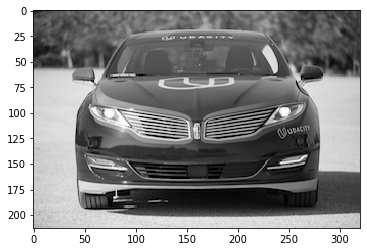

In [2]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

# TODO: Feel free to try out your own images here by changing img_path
# to a file path to another image on your computer!
img_path = 'data/udacity_sdc.png'

# load color image 
bgr_img = cv2.imread(img_path)
# convert to grayscale
gray_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2GRAY)

# normalize, rescale entries to lie in [0,1]
gray_img = gray_img.astype("float32")/255

# plot image
plt.imshow(gray_img, cmap='gray')
plt.show()

### Define and visualize the filters

In [3]:
import numpy as np

## TODO: Feel free to modify the numbers here, to try out another filter!
filter_vals = np.array([[-1, -1, 1, 1], [-1, -1, 1, 1], [-1, -1, 1, 1], [-1, -1, 1, 1]])

print('Filter shape: ', filter_vals.shape)


Filter shape:  (4, 4)


In [4]:
# Defining four different filters, 
# all of which are linear combinations of the `filter_vals` defined above

# define four filters
filter_1 = filter_vals
filter_2 = -filter_1
filter_3 = filter_1.T
filter_4 = -filter_3
filters = np.array([filter_1, filter_2, filter_3, filter_4])

# Print out the values of filters
print('Filters: \n', filters)

Filters: 
 [[[-1 -1  1  1]
  [-1 -1  1  1]
  [-1 -1  1  1]
  [-1 -1  1  1]]

 [[ 1  1 -1 -1]
  [ 1  1 -1 -1]
  [ 1  1 -1 -1]
  [ 1  1 -1 -1]]

 [[-1 -1 -1 -1]
  [-1 -1 -1 -1]
  [ 1  1  1  1]
  [ 1  1  1  1]]

 [[ 1  1  1  1]
  [ 1  1  1  1]
  [-1 -1 -1 -1]
  [-1 -1 -1 -1]]]


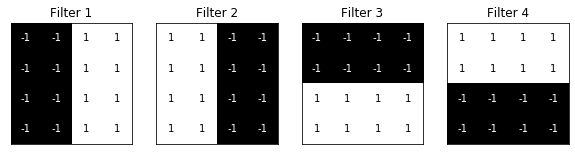

In [5]:
# visualize all four filters
fig = plt.figure(figsize=(10, 5))
for i in range(4):
    ax = fig.add_subplot(1, 4, i+1, xticks=[], yticks=[])
    ax.imshow(filters[i], cmap='gray')
    ax.set_title('Filter %s' % str(i+1))
    width, height = filters[i].shape
    for x in range(width):
        for y in range(height):
            ax.annotate(str(filters[i][x][y]), xy=(y,x),
                        horizontalalignment='center',
                        verticalalignment='center',
                        color='white' if filters[i][x][y]<0 else 'black')

## Define a convolutional layer 

The various layers that make up any neural network are documented, [here](http://pytorch.org/docs/stable/nn.html). For a convolutional neural network, we'll start by defining a:
* Convolutional layer

Initialize a single convolutional layer so that it contains all your created filters. Note that you are not training this network; you are initializing the weights in a convolutional layer so that you can visualize what happens after a forward pass through this network!


#### `__init__` and `forward`
To define a neural network in PyTorch, you define the layers of a model in the function `__init__` and define the forward behavior of a network that applyies those initialized layers to an input (`x`) in the function `forward`. In PyTorch we convert all inputs into the Tensor datatype, which is similar to a list data type in Python. 

Below, I define the structure of a class called `Net` that has a convolutional layer that can contain four 3x3 grayscale filters.

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
    
# define a neural network with a single convolutional layer with four filters
class Net(nn.Module):
    
    def __init__(self, weight):
        super(Net, self).__init__()
        # initializes the weights of the convolutional layer to be the weights of the 4 defined filters
        k_height, k_width = weight.shape[2:] # Setting the filter size (4x4)
        # assumes there are 4 grayscale filters
        self.conv = nn.Conv2d(1, 4, kernel_size=(k_height, k_width), bias=False)
        # Initializing the weights
        self.conv.weight = torch.nn.Parameter(weight)
        
    def forward(self, x):
        # calculates the output of a convolutional layer
        # pre- and post-activation
        conv_x = self.conv(x)
        activated_x = F.relu(conv_x)
        
        # returns both layers
        return conv_x, activated_x
    
# instantiate the model and set the weights
weight = torch.from_numpy(filters).unsqueeze(1).type(torch.FloatTensor)
print(weight)
print(weight.shape)
model = Net(weight)

# print out the layer in the network
print(model)

tensor([[[[-1., -1.,  1.,  1.],
          [-1., -1.,  1.,  1.],
          [-1., -1.,  1.,  1.],
          [-1., -1.,  1.,  1.]]],


        [[[ 1.,  1., -1., -1.],
          [ 1.,  1., -1., -1.],
          [ 1.,  1., -1., -1.],
          [ 1.,  1., -1., -1.]]],


        [[[-1., -1., -1., -1.],
          [-1., -1., -1., -1.],
          [ 1.,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  1.]]],


        [[[ 1.,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  1.],
          [-1., -1., -1., -1.],
          [-1., -1., -1., -1.]]]])
torch.Size([4, 1, 4, 4])
Net(
  (conv): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), bias=False)
)


### Visualize the output of each filter

First, we'll define a helper function, `viz_layer` that takes in a specific layer and number of filters (optional argument), and displays the output of that layer once an image has been passed through.

In [22]:
# helper function for visualizing the output of a given layer
# default number of filters is 4
def viz_layer(layer, n_filters= 4):
    fig = plt.figure(figsize=(20, 20))
    
    for i in range(n_filters):
        ax = fig.add_subplot(1, n_filters, i+1, xticks=[], yticks=[])
        # grab layer outputs
        ax.imshow(np.squeeze(layer[0,i].data.numpy()), cmap='gray')
        ax.set_title('Output %s' % str(i+1))

Let's look at the output of a convolutional layer, before and after a ReLu activation function is applied.

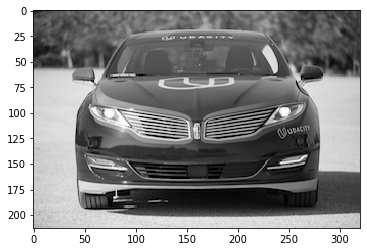

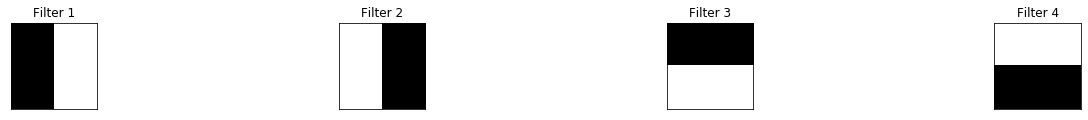

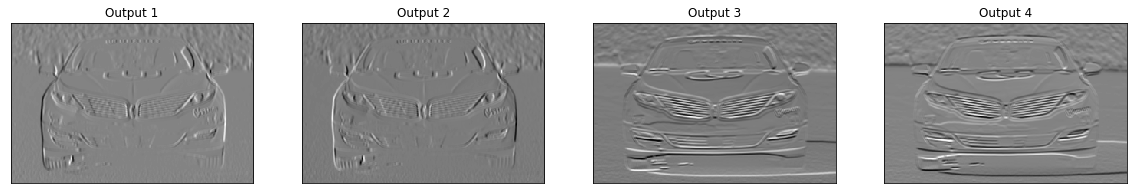

In [23]:
# plot original image
plt.imshow(gray_img, cmap='gray')

# visualize all filters
fig = plt.figure(figsize=(12, 6))
fig.subplots_adjust(left=0, right=1.5, bottom=0.8, top=1, hspace=0.05, wspace=0.05)
for i in range(4):
    ax = fig.add_subplot(1, 4, i+1, xticks=[], yticks=[])
    ax.imshow(filters[i], cmap='gray')
    ax.set_title('Filter %s' % str(i+1))

    
# convert the image into an input Tensor
gray_img_tensor = torch.from_numpy(gray_img).unsqueeze(0).unsqueeze(1)

# get the convolutional layer (pre and post activation)
conv_layer, activated_layer = model(gray_img_tensor)

# visualize the output of a conv layer
viz_layer(conv_layer)

#### ReLu activation

In this model, we've used an activation function that scales the output of the convolutional layer. We've chose a ReLu function to do this, and this function simply turns all negative pixel values in 0's (black). See the equation pictured below for input pixel values, `x`. 

<img src='notebook_ims/relu_ex.png' height=50% width=50% />

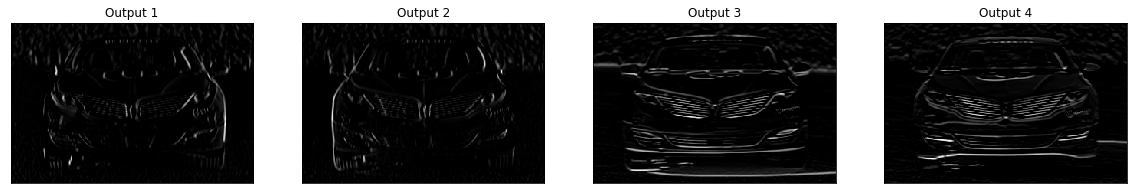

In [24]:
# after a ReLu is applied
# visualize the output of an activated conv layer
viz_layer(activated_layer)